# Detecting abnormal meal prices

There's a list of meal reimbursements made using the CEAP. We want to alert about anomalies found in this dataset based on known information about food expenses. By the start, me and @filipelinhares are proposing grouping the congressperson that had reimbursement at the same places and same days to find how the consumption behave.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
reimbursements = pd.read_csv('../data/2016-11-22-reimbursements.xz',
                      dtype={'document_id': np.str,
                          'congressperson_id': np.str,
                          'congressperson_name': np.str,
                          'congressperson_document': np.str,
                          'term_id': np.str,
                          'cnpj_cpf': np.str,
                          'reimbursement_number': np.str},
                      low_memory=False)

In [3]:
reimbursements['issue_date'] = pd.to_datetime(reimbursements['issue_date'], errors='coerce')
reimbursements.sort_values('issue_date', inplace=True)

## Data preparation

In [4]:
meals = reimbursements[reimbursements.subquota_description == 'Congressperson meal']
meals.head()

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,issue_date,document_value,remark_value,net_values,month,installment,passenger,leg_of_the_trip,batch_number,reimbursement_values
142274,2011,2303,2003049,NaN,80.00,3554,RONALDO ZULKE,160594,515,2011.0,...,2001-02-01,80.00,0.0,80.00,2,0,NaN,NaN,519202,NaN
201776,2011,676,1996616,NaN,28.73,3531,JOÃO ALMEIDA,74549,198,2007.0,...,2011-01-01,28.73,0.0,28.73,1,0,NaN,NaN,515986,NaN
82238,2011,1880,1987343,NaN,107.00,3506,LUIZ PAULO VELLOZO LUCAS,141489,278,2007.0,...,2011-01-01,107.00,0.0,107.00,1,0,NaN,NaN,513294,NaN
201785,2011,676,1996628,NaN,3.00,3531,JOÃO ALMEIDA,74549,198,2007.0,...,2011-01-01,3.00,0.0,3.00,1,0,NaN,NaN,515987,NaN
8043,2011,1071,1986899,NaN,147.00,3506,JOSÉ ROCHA,74554,203,2015.0,...,2011-01-01,147.00,0.0,147.00,1,0,NaN,NaN,513139,NaN


In [5]:
meals.total_net_value.describe()

count    150316.000000
mean         65.572395
std          98.094630
min           0.010000
25%          25.000000
50%          46.200000
75%          84.640000
max        6205.000000
Name: total_net_value, dtype: float64

In [6]:
meals = meals[meals['congressperson_id'].notnull()]
meals.shape

(149470, 31)

In [7]:
# grouped = meals.groupby('cnpj_cpf', as_index=False)
# print('{} total cnpj/cpfs, {} are unique'.format(len(meals), len(grouped)))

In [8]:
# cnpj_cpfs = []
# names = []
# for group in grouped:
#     cnpj_cpfs.append(group[0])
#     names.append(group[1].iloc[0].supplier)

# names = pd.DataFrame({'cnpj_cpf': cnpj_cpfs, 'supplier_name': names})
# names.head()

## CNPJs/CPFs that received the most expenses in days.

In [18]:
keys = ['cnpj_cpf', 'supplier', 'issue_date']
aggregation = meals.groupby(keys)['total_net_value']. \
    agg({'sum': np.sum, 'expenses': len, 'mean': np.mean})

As we observe, there's a place that received 73 reimburses in one day, by now we are looking for a way to know what congressperson had lunch in those places and how many they had paid for it, in order to find if some of those congressperson had an abnormal expense.

In [19]:
by_day_desc = aggregation.sort_values(['expenses', 'sum'], ascending=[False, False])
by_day_desc.head()

mean  \
cnpj_cpf       supplier                                        issue_date              
33469172000672 SERVIÇO NAC. DE APRENDIZAGEM COMERCIAL - SENAC  2016-05-24  24.047671   
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-18  45.751000   
                                                               2015-05-06  46.452281   
33469172000672 SERV. NAC. DE APRENDIZAGEM COMERCIAL - SENAC    2015-03-11  18.285714   
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-17  44.775636   

                                                                               sum  \
cnpj_cpf       supplier                                        issue_date            
33469172000672 SERVIÇO NAC. DE APRENDIZAGEM COMERCIAL - SENAC  2016-05-24  1755.48   
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-18  2745.06   
                                                               2015-05-06  2647.78   
33469172000672 SERV. NAC. DE APRENDIZAGEM COMERCIAL - SENAC    2015-03-11  1024.00   
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-17  2462.66   

                                                                           expenses  
cnpj_cpf       supplier                                        issue_date            
33469172000672 SERVIÇO NAC. DE APRENDIZAGEM COMERCIAL - SENAC  2016-05-24      73.0  
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-18      60.0  
                                                               2015-05-06      57.0  
33469172000672 SERV. NAC. DE APRENDIZAGEM COMERCIAL - SENAC    2015-03-11      56.0  
33469172001644 SENAC - COMP. ADM. CAM. DEP. ANEXO IV 10º ANDAR 2015-03-17      55.0

Sorting expenses with greater sum we can find a lot of one expense in hotels.

In [20]:
by_day_asc = aggregation.sort_values(['expenses', 'sum'], ascending=[True, False])
by_day_asc.head()

,,,mean,sum,expenses
cnpj_cpf,supplier,issue_date,,,
04780541000130,VR COMERCIO DE VEICULOS LTDA-ME,2015-01-18,5880.0,5880.0,1.0
72629140000134,HOTEL NACIONAL SA,2011-11-02,4510.0,4510.0,1.0
00777156000183,AUTO POSTO CAPITAL LTDA,2013-05-09,4507.0,4507.0,1.0
14922838000147,Elizangela tatiana Kinoshita Martini ME,2015-09-15,3900.0,3900.0,1.0
26418749000147,PAULO OCTAVIO HOTEIS E TURISMO LTDA,2015-11-10,3041.8,3041.8,1.0


Sort places with just one expense by day

In [21]:
one_expense_by_day = by_day_asc[by_day_asc['expenses'] <= 1]
one_expense_by_day.head()

,,,mean,sum,expenses
cnpj_cpf,supplier,issue_date,,,
04780541000130,VR COMERCIO DE VEICULOS LTDA-ME,2015-01-18,5880.0,5880.0,1.0
72629140000134,HOTEL NACIONAL SA,2011-11-02,4510.0,4510.0,1.0
00777156000183,AUTO POSTO CAPITAL LTDA,2013-05-09,4507.0,4507.0,1.0
14922838000147,Elizangela tatiana Kinoshita Martini ME,2015-09-15,3900.0,3900.0,1.0
26418749000147,PAULO OCTAVIO HOTEIS E TURISMO LTDA,2015-11-10,3041.8,3041.8,1.0


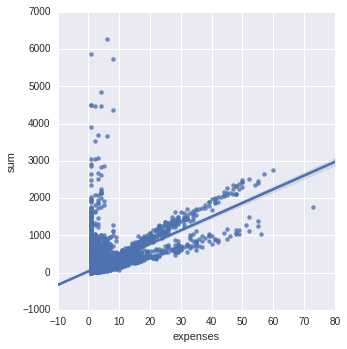

In [22]:
sns.lmplot('expenses', 'sum',
            data=by_day_asc)